Train a model for [hand sign images](https://www.kaggle.com/datasets/ash2703/handsignimages) dataset using MobileNet for transfer learning.

#Import Dependencies

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
import string
import random
from random import randint
import cv2 as cv
import os
import itertools

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import MobileNet
from keras import models
from keras.models import Sequential, Model
from keras import layers
from keras.layers import Conv2D,MaxPool2D,GlobalAveragePooling2D,AveragePooling2D
from keras.layers import Dense,Dropout,Activation,Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, classification_report

from google.colab import drive
drive.mount('/content/drive')

#Create main variables

In [ ]:
root_path = '/content/drive/MyDrive/Universidad/Deep_Learning/Final_Project'

data_path = root_path + '/Dataset'

train_path = data_path + "/Train"
test_path = data_path + "/Test"

target_size_width = 32 #depends on MobileNet input
target_size_height = 32
input_shape = (target_size_height, target_size_width)

batch_size = 128
num_classes = 24 #All letters excluding J and Z
epochs = 10
split = 0.3

#Preprocess Dataset

In [ ]:
def gray_to_rgb(img):
    return np.repeat(img, 3, 2)

In [ ]:
#train_datagen = ImageDataGenerator(rescale = 1/255, validation_split = split, preprocessing_function=gray_to_rgb)

#test_datagen = ImageDataGenerator(rescale = 1/255, preprocessing_function=gray_to_rgb)

train_datagen = ImageDataGenerator(rescale = 1/255, validation_split = split)

test_datagen = ImageDataGenerator(rescale = 1/255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = input_shape,
    batch_size = batch_size,
    class_mode = "sparse",
    color_mode='rgb',
    subset = 'training'
    )

validation_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = input_shape,
    batch_size = batch_size,
    class_mode = "sparse",
    color_mode='rgb',
    subset = 'validation'
    )

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size = input_shape,
    batch_size = batch_size,
    class_mode = "sparse",
    color_mode='rgb'
    )

Found 19229 images belonging to 24 classes.
Found 8226 images belonging to 24 classes.
Found 7172 images belonging to 24 classes.


In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img[:,:,0])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

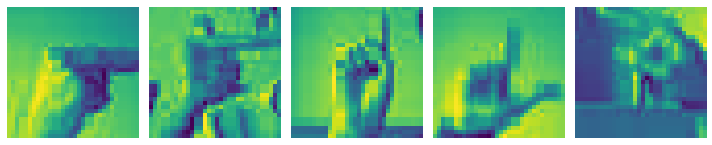

In [ ]:
sample_training_images, _ = next(train_generator)
plotImages(sample_training_images[:5])

#Create Neural Network Architecture

In [ ]:
 # imports the mobilenet model and discards the last 1000 neuron layer.
base_model = MobileNet(input_shape=(32,32,3), weights='imagenet', include_top=False)
base_model.trainable = False

inputs = base_model.input
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)  # we add dense layers so that the model can learn more complex functions and classify for better results.
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)  # dense layer 2
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)  # dense layer 3
x = Dropout(0.2)(x)


outputs = Dense(num_classes, activation='softmax')(x)  # final layer with softmax activation
model = Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 1, 1, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328

#Training

In [ ]:
#Se puede programar el entrenamiento para que haga un early stopping que dependa del error de validación
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

#Se puede configurar para que guarde el mejor modelo que se dé durante el entrenamiento, mejor dependiendo el error de validación.
mcp_save = ModelCheckpoint(root_path+'/keras-models/'+str(time.time())+"-weights-check.h5", save_best_only=True, monitor='val_loss', mode='min')

#Reduce el LR si se queda estancado el entrenamiento, basándose en el error de validación
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')

In [ ]:
model.compile(
    #optimizer = RMSprop(lr = 0.001),
    optimizer = 'adam',
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)

history = model.fit(
    train_generator,
    epochs=epochs,
    callbacks = [earlyStopping, mcp_save, reduce_lr_loss],
    validation_data = validation_generator
)

Epoch 1/10
151/151 [==============================] - 4879s 32s/step - loss: 2.9703 - accuracy: 0.1066 - val_loss: 2.6919 - val_accuracy: 0.1681 - lr: 0.0010
Epoch 2/10
151/151 [==============================] - 58s 384ms/step - loss: 2.6621 - accuracy: 0.1684 - val_loss: 2.5425 - val_accuracy: 0.2054 - lr: 0.0010
Epoch 3/10
151/151 [==============================] - 57s 379ms/step - loss: 2.5597 - accuracy: 0.1929 - val_loss: 2.4672 - val_accuracy: 0.2249 - lr: 0.0010
Epoch 4/10
151/151 [==============================] - 58s 387ms/step - loss: 2.5093 - accuracy: 0.2073 - val_loss: 2.4307 - val_accuracy: 0.2309 - lr: 0.0010
Epoch 5/10
151/151 [==============================] - 58s 387ms/step - loss: 2.4725 - accuracy: 0.2145 - val_loss: 2.3921 - val_accuracy: 0.2418 - lr: 0.0010
Epoch 6/10
151/151 [==============================] - 57s 380ms/step - loss: 2.4368 - accuracy: 0.2218 - val_loss: 2.3578 - val_accuracy: 0.2614 - lr: 0.0010
Epoch 7/10
151/151 [==============================] 

#Evaluate

In [ ]:
results = model.evaluate(test_generator)

57/57 [==============================] - 1230s 22s/step - loss: 2.5988 - accuracy: 0.1949


#Results

Create function to graph results.

In [ ]:
def plot_history(Exp_history, epochs):
  plt.figure(1)
  plt.subplot(211)
  plt.plot(list(range(1, epochs+1)),Exp_history.history['accuracy'])
  plt.plot(list(range(1, epochs+1)),Exp_history.history['val_accuracy'])
  plt.title('Accuracy')
  plt.ylabel('accuracy')
  plt.legend(['Train', 'Validation'], loc='best')
  plt.subplot(212)
  plt.plot(list(range(1, epochs+1)),Exp_history.history['loss'])
  plt.plot(list(range(1, epochs+1)),Exp_history.history['val_loss'])
  plt.title('Loss')
  plt.ylabel('loss')
  plt.xlabel('epoches')
  plt.legend(['Train', 'Validation'], loc='best')
  plt.tight_layout()
  plt.show()

Plot the performance of the network during training using the *accuracy* and the *loss* metrics.

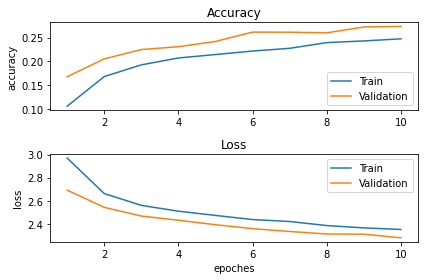

In [ ]:
plot_history(history,epochs)

#Save model

Save the final model after the training.

In [ ]:
model.save(root_path+'/keras-models/'+str(time.time())+"_TL_trainModel.h5")

#Predict

Create function to decode the prediction to a playlist recommendation.

In [ ]:
'''
def testModel(alphabet = "A"):
    dirname, _, filenames = list(os.walk(f'/content/drive/MyDrive/Universidad/Deep_Learning/Final_Project/Dataset/Test{alphabet.upper()}'))[0]
    img_path = os.path.join(dirname, filenames[randint(0, len(filenames))])
    print(img_path)
    img = cv.imread(img_path, 0).reshape(1, 28, 28, 1)
    pred = model.predict(img)
    pred_label = classes[np.argmax(pred)]

    plt.title(pred_label)
    plt.imshow(img[0,:,:,0], cmap = "gray")
'''

'\ndef testModel(alphabet = "A"):\n    dirname, _, filenames = list(os.walk(f\'/content/drive/MyDrive/Universidad/Deep_Learning/Final_Project/Dataset/Test{alphabet.upper()}\'))[0]\n    img_path = os.path.join(dirname, filenames[randint(0, len(filenames))])\n    print(img_path)\n    img = cv.imread(img_path, 0).reshape(1, 28, 28, 1)\n    pred = model.predict(img)\n    pred_label = classes[np.argmax(pred)]\n\n    plt.title(pred_label)\n    plt.imshow(img[0,:,:,0], cmap = "gray")\n'

In [ ]:
#testModel("m")

#Create Confussion matrix

In [ ]:
#Crear vectores y_true, y_pred

In [ ]:
'''
cm = confusion_matrix(y_true=y, y_pred=x)
print(cm)
'''

'\ncm = confusion_matrix(y_true=y, y_pred=x)\nprint(cm)\n'

In [ ]:
'''
classes = [char for char in string.ascii_uppercase if char != "J" if char != "Z"]
print(classes, end = " ")
'''

'\nclasses = [char for char in string.ascii_uppercase if char != "J" if char != "Z"]\nprint(classes, end = " ")\n'

In [ ]:
'''
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
'''

'\ndef plot_confusion_matrix(cm, classes,\n                        normalize=False,\n                        title=\'Confusion matrix\',\n                        cmap=plt.cm.Blues):\n    """\n    This function prints and plots the confusion matrix.\n    Normalization can be applied by setting `normalize=True`.\n    """\n    plt.imshow(cm, interpolation=\'nearest\', cmap=cmap)\n    plt.title(title)\n    plt.colorbar()\n    tick_marks = np.arange(len(classes))\n    plt.xticks(tick_marks, classes, rotation=45)\n    plt.yticks(tick_marks, classes)\n\n    if normalize:\n        cm = cm.astype(\'float\') / cm.sum(axis=1)[:, np.newaxis]\n        print("Normalized confusion matrix")\n    else:\n        print(\'Confusion matrix, without normalization\')\n\n    print(cm)\n\n    thresh = cm.max() / 2.\n    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):\n        plt.text(j, i, cm[i, j],\n            horizontalalignment="center",\n            color="white" if cm[i, j] > thre

In [ ]:
#plot_confusion_matrix(cm,classes,title='Matriz de Confusión')